[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/014_clasificacion_binaria/clasificacion_binaria.ipynb)

# Clasificación Binaria

![](https://www.researchgate.net/profile/Shibani_Singh2/publication/321141639/figure/fig2/AS:572731935727616@1513561342872/Schematic-of-Rosenblatts-perceptron.png)

Este modelo está inspirado en el funcionamiento de las neuronas biológicas que forman las redes neuronales de nuestros cerebros, recibiendo una serie de señales de entrada y devolviendo un resultado a la salida, calculando una suma ponderada de todos los *inputs* y aplicando una función de activación.

$$ \hat{y} = f(\mathbf{w} \cdot \mathbf{x}) = f(w_0 + w_1 x_1 + ... + w_m x_m) $$

También vimos cómo aplicar este sencillo algoritmo para la tarea de regresión lineal, en la que el objetivo es dar un valor numérico real a partir de una serie de características de entrada. Aprendimos que podemos encontrar los pesos $\mathbf{w}$ de nuestro modelo utilizando el algoritmo de optimización conocido como `descenso por gradiente` en el que minimizamos una `función de pérdida`. En este post vamos a ver una nueva aplicación del `Perceptrón`: `clasificación binaria`. En esta tarea nuestro objetivo es dar como resultado si una muestra pertenece a una clase en particular o no a partir de sus características.

> 💡 Para el problema de regresión lineal usamos el ejemplo de predicción de precios de inmuebles a partir de características como el número de habitaciones o los metros cuadrados. En el caso de clasificación binaria podemos pensar en un sistema de ayuda al diagnóstico médico en el que nuestro modelo tiene que decirnos si un paciente tiene una enfermedad o no a partir de valores como su edad, peso, temperatura, síntomas, etc.

## Función de Activación

Para el problema de regresión lineal vimos que tenemos que utilizar una función de activación lineal, de manera que nuestro modelo sea capaz de dar como resultado cualquier valor real entre $- \infty$ y $\infty$. En el caso de la clasificación binaria queremos que nuestro modelo sólo nos de dos valores: $0$ ó $1$. Para ello utilizamos la función de activación `step`.

$$ \hat{y} = \mathrm{step}(\mathbf{w} \cdot \mathbf{x}) = \mathrm{step}(w_0 + w_1 x_1 + ... + w_m x_m) $$

dónde la función `step` da como resultado $0$ si $\mathbf{w} \cdot \mathbf{x} \leq 0$ o bien $1$ si $\mathbf{w} \cdot \mathbf{x} > 0$. 

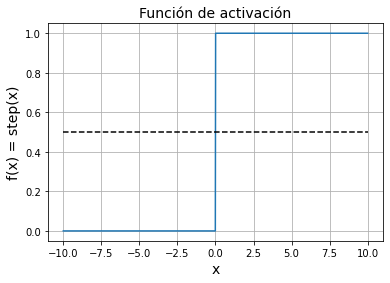

In [1]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-10, 10, 1000)
y = x > 0

plt.plot(x, y)
plt.grid(True)
plt.xlabel('x', fontsize=14)
plt.ylabel('f(x) = step(x)', fontsize=14)
plt.title('Función de activación', fontsize=14)
plt.plot(x, np.full(len(x), 0.5), '--k')
plt.show()

## El Dataset

Vamos ahora a ver cómo entrenar nuestro `Preceptrón` para clasificación binaria. Para ello, primero necesitamos un conjunto de datos formado por un número determinado de elementos con varias características acompañados de sus correspondiente clase (o etiqueta). En este post vamos a utilizar un dataset muy utilizado en el ámbito académico muy útil para aprender a desarrollar modelos de clasificación: El dataset [Iris](https://archive.ics.uci.edu/ml/datasets/iris). Este dataset contiene ejemplos de flores que tendremos que clasificar en 3 grupos diferentes a partir del ancho y longitud de sus pétalos y sépalos (en total 4 características). Este dataset está disponible a través de la librería [Scikit Learn](https://scikit-learn.org/stable/), sobre la que hablaremos más adelante. 

In [2]:
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = iris.target

X.shape, y.shape

((150, 2), (150,))

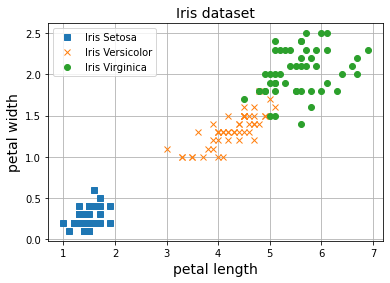

In [3]:
plt.plot(X[y==0, 0], X[y==0, 1], 's', label="Iris Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], 'x', label="Iris Versicolor")
plt.plot(X[y==2, 0], X[y==2, 1], 'o', label="Iris Virginica")
plt.grid()
plt.legend()
plt.xlabel('petal length', fontsize=14)
plt.ylabel('petal width', fontsize=14)
plt.title("Iris dataset", fontsize=14)
plt.show()

Para poder llevar a cabo visualizaciones ilustrativas, vamos a trabajar sólo con dos de las cuatro características: la longitud y ancho del pétalo. Cómo puedes observar, el dataset está compuesto por 150 flores. Cada flor tiene su correspondiente etiqueta, y hay 3 clases en total. En este ejemplo, al querer llevar a cabo una tarea de clasificación binaria, vamos a juntar dos de las clases para trabajar con solo una de ellas.

In [4]:
# dividiendo el set en dos grupos 
y = (iris.target == 0).astype(np.int) # convertir el booleano a entero

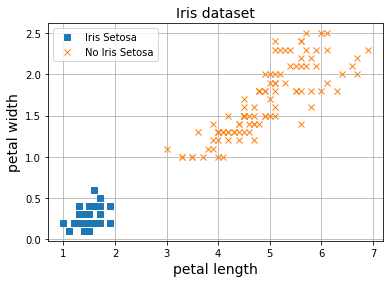

In [5]:
plt.plot(X[y==1, 0], X[y==1, 1], 's', label="Iris Setosa")
plt.plot(X[y==0, 0], X[y==0, 1], 'x', label="No Iris Setosa")
plt.grid()
plt.legend()
plt.xlabel('petal length', fontsize=14)
plt.ylabel('petal width', fontsize=14)
plt.title("Iris dataset", fontsize=14)
plt.show()

Así pues, nuestro objetivo será el de entrenar un `Perceptrón` que sea capaz de distinguir entre flores de tipo `Iris Setosa` y `No Iris Setosa` a partir del ancho y longitud de sus pétalos (clasificación binaria). Para ello utilizaremos exactamente el mismo algoritmo de entrenamiento que ya conocemos de posts anteriores: el algoritmo de `descenso por gradiente`.

## Entrenando el Perceptrón

Utilizamos el algoritmo de descenso por gradiente para encontrar los pesos de nuestro perceptrón que nos permitan llevar a cabo nuestra tarea. Si no estás familiarizado con este algoritmo, te recomiendo que eches un vistazo a los posts anteriores en los que desarrollamos el algoritmo. A continuación puedes ver la implementación de un `Perceptrón` para llevar a cabo nuestra tarea.

In [6]:
class Perceptron():
  def __init__(self, size):
    self.w = np.random.randn(size) #definiendo el peso 
    self.ws = []

  #Funcion de activacion
  def __call__(self, w, x):
    return np.dot(x, w) > 0 

  def fit(self, x, y, epochs, lr):
    #añadir una columna de unos al principio np.ones(len(x))
    '''
    Para poder hacer el producto escalar de los pesos por las entradas 
    es necesario agregar estos unos a escalar, para posteriormente poder hacer 
    el producto escalar de (w1)(x1) + (w2)(x2)
    '''
    x = np.c_[np.ones(len(x)), x]
    for epoch in range(epochs):
        # Batch Gradient Descent SAlida del perceptron
        y_hat = self(self.w, x)  
        # función de pérdida (MSE)
        # y = los valores reales
        # se calcula el valor medio cuadratico con np.mean  
        l = np.mean((y_hat - y)**2) 
        # derivadas 
        dldh = 2.*(y_hat - y)
        dhdw = x
        # Derivada de perdida con respecto de los pesos 
        dldw = np.dot(dldh, dhdw)
        # actualizar pesos
        self.w = self.w - lr*dldw
        # guardar pesos para animación
        self.ws.append(self.w.copy())

Vamos a ver qué hace nuestra clase `Perceptrón` función a función:

- `__init__`: Este es el constructor de la clase, estará encargado de inicializar los pesos del modelo, $\mathbf{w}$. Al estar trabajando con dos características, necesitaremos 3 pesos: $w_0$, el bias, y $w_1$ y $w_2$, los pesos que multiplicarán el ancho y longitud del peso respectivamente.
- `__call__`: Esta es la función que calculará la salida del perceptrón, $\hat{y}$, a partir de las entradas, $\mathbf{x}$. Este valor será $0$ o $1$ dependiendo del signo de la suma ponderada de los valores de entrada con los pesos del modelo.
- `fit`: Esta es la función que entrenará el modelo (el nombre *fit* es bastante utilizado en las librerías de `machine learning` para referirse al proceso de entrenamiento). En ella aplicaremos el algoritmo de descenso por gradiente:
    1. Calculamos la salida del modelo
    2. Calculamos la derivada de la función de pérdida con respecto a los pesos del modelo
    3. Actualizamos los pesos en la dirección negativa de la derivada para reducir el error.
    4. Repetimos hasta convergencia (o en este caso por un número determinado de iteraciones, o *epochs*).

> ⚡ Date cuenta que en la función `fit` añadimos una columna de unos al principio de la matriz $x$. Nuestros pesos están definidos en el vector $\mathbf{w} = [w_0, w_1, w_2]$ sin embargo los datos están en $\mathbf{x} = [x_1, x_2]$ en el que cada columna representa una de las características. Para poder llevar a cabo la operación $\mathbf{w} \cdot \mathbf{x}$ aplicando el término del *bias* tenemos que añadir esta columna extra, $\mathbf{x} = [1, x_1, x_2]$, de manera que $\mathbf{w} \cdot \mathbf{x} = w_0 + w_1 x_1 + w_2 x_2$. 

Ahora podemos entrenar nuestro perceptrón.

In [7]:
np.random.seed(42) # semilla

perceptron = Perceptron(3) # instancia del perceptron con 3 pesos 
epochs, lr = 10, 0.01
perceptron.fit(X, y, epochs, lr)

In [8]:
from matplotlib import animation, rc
from matplotlib.colors import ListedColormap

custom_cmap = ListedColormap(['#9898ff', '#fafab0'])
rc('animation', html='html5')

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, autoscale_on=False)
def plot(i, axes = [0, 5, 0, 2], label="Iris Setosa"):
    ax.clear()
    w = perceptron.ws[i]
    tit = ax.set_title(f"Epoch {i+1}", fontsize=14)
    x0, x1 = np.meshgrid(
            np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
            np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
        )
    X_new = np.c_[x0.ravel(), x1.ravel()]
    X_new = np.c_[np.ones(len(X_new)), X_new] 
    y_predict = perceptron(w, X_new)
    zz = y_predict.reshape(x0.shape)
    ax.plot(X[y==0, 0], X[y==0, 1], "bs", label=f"No {label}")
    ax.plot(X[y==1, 0], X[y==1, 1], "yo", label=label)
    ax.contourf(x0, x1, zz, cmap=custom_cmap)
    ax.set_xlabel("Petal length", fontsize=14)
    ax.set_ylabel("Petal width", fontsize=14)
    ax.legend(loc="lower right", fontsize=14)
    ax.axis(axes)
    return ax

anim = animation.FuncAnimation(fig, plot, frames=epochs, interval=200)
plt.close()
anim

Cómo puedes observar, los valores iniciales de los pesos del modelo no son capaces de separar ambas clases ya que esta inicialización es aleatoria. Sin embargo, en cada iteración, vamos actualizando los pesos aumentando el número de flores que el modelo clasifica correctamente hasta llegar a separar completamente las dos clases. En este punto nuestro modelo ya está entrenado y podemos utilizarlo para saber a que clase pertenece una flor a partir de la longitud y ancho de sus pétalos.

In [ ]:
# últimos pesos encontrados

w = perceptron.ws[-1]
w

array([ 4.41671415, -1.2682643 , -1.24231146])

In [ ]:
x_new = [1, 2, 0.5]
y_pred = perceptron(w, x_new)
y_pred # Iris Setosa

True

In [ ]:
x_new = [1, 4, 0.5]
y_pred = perceptron(w, x_new)
y_pred # No Iris Setosa

False

## Normalización

En el ejemplo anterior hemos utilizado el dataset tal cual nos lo da la librería Scikit Learn. Algunos algoritmos, sin embargo, funcionan mejor cuando los datos que utilizamos están normalizados. El `Perceptrón` es uno de estos algoritmos. Podemos normalizar los datos de varias formas, las más comunes son las siguientes:

In [ ]:
# Normalizamos entre 0 y 1

print(X.max(axis=0), X.min(axis=0))

X_norm = (X - X.min(axis=0))/(X.max(axis=0)-X.min(axis=0))

print(X_norm.max(axis=0), X_norm.min(axis=0))

[6.9 2.5] [1.  0.1]
[1. 1.] [0. 0.]


In [ ]:
# Normalizamos con valor medio 0 y desviación estándar 1

print(X.mean(axis=0), X.std(axis=0))

X_mean, X_std = X.mean(axis=0), X.std(axis=0)
X_norm = (X - X_mean) / X_std

print(X_norm.mean(axis=0), X_norm.std(axis=0))

[3.758      1.19933333] [1.75940407 0.75969263]
[-4.26325641e-16 -4.73695157e-16] [1. 1.]


Ambas alternativas pueden funcionar, en esta caso usaremos la normalización con valor medio $0$ y desviación estándar $1$.

In [ ]:
np.random.seed(42)

perceptron = Perceptron(3)
epochs, lr = 20, 0.1
perceptron.fit(X_norm, y, epochs, lr)

In [ ]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, autoscale_on=False)
def plot(i, axes = [0, 5, 0, 2], label="Iris Setosa"):
    ax.clear()
    w = perceptron.ws[i]
    tit = ax.set_title(f"Epoch {i+1}", fontsize=14)
    x0, x1 = np.meshgrid(
            np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
            np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
        )
    X_new = (np.c_[x0.ravel(), x1.ravel()] - X_mean)/X_std
    X_new = np.c_[np.ones(len(X_new)), X_new] 
    y_predict = perceptron(w, X_new)
    zz = y_predict.reshape(x0.shape)
    ax.plot(X[y==0, 0], X[y==0, 1], "bs", label=f"No {label}")
    ax.plot(X[y==1, 0], X[y==1, 1], "yo", label=label)
    ax.contourf(x0, x1, zz, cmap=custom_cmap)
    ax.set_xlabel("Petal length", fontsize=14)
    ax.set_ylabel("Petal width", fontsize=14)
    ax.legend(loc="lower right", fontsize=14)
    ax.axis(axes)
    return ax

anim = animation.FuncAnimation(fig, plot, frames=epochs, interval=200)
plt.close()
anim

## Limitaciones

De la misma forma que vimos cómo el `Perceptrón` falla en la tarea de regresión lineal con datos no lineales, observamos el mismo problema en el caso de la clasificación binaria. En el ejemplo anterior nuestros datos se podían separar fácilmente mediante una línea recta. En los casos en los que esto no sea posible (lo cual ocurrirá prácticamente siempre), nuestro `Perceptrón` no será suficiente y necesitaremos modelos más complejos. Vamos a ver esta limitación para intentar separar flores de tipo `Iris Versicolor` del resto.

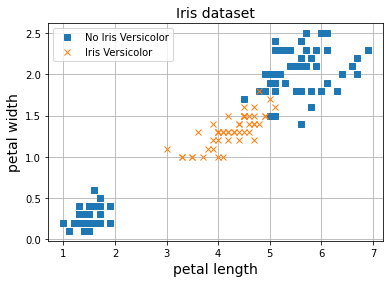

In [ ]:
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 1).astype(np.int)

plt.plot(X[y==0, 0], X[y==0, 1], 's', label="No Iris Versicolor")
plt.plot(X[y==1, 0], X[y==1, 1], 'x', label="Iris Versicolor")
plt.grid()
plt.legend()
plt.xlabel('petal length', fontsize=14)
plt.ylabel('petal width', fontsize=14)
plt.title("Iris dataset", fontsize=14)
plt.show()

In [ ]:
X_norm = (X - X.min(axis=0))/(X.max(axis=0)-X.min(axis=0))
np.random.seed(20)

perceptron = Perceptron(3)
epochs, lr = 40, 0.01
perceptron.fit(X_norm, y, epochs, lr)

In [ ]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, autoscale_on=False)
def plot(i, axes = [0.5, 7.3, 0, 2.8], label="Iris Versicolor"):
    ax.clear()
    w = perceptron.ws[i]
    tit = ax.set_title(f"Epoch {i+1}", fontsize=14)
    x0, x1 = np.meshgrid(
            np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
            np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
        )
    X_new = (np.c_[x0.ravel(), x1.ravel()] - X_mean)/X_std
    X_new = np.c_[np.ones(len(X_new)), X_new] 
    y_predict = perceptron(w, X_new)
    zz = y_predict.reshape(x0.shape)
    ax.plot(X[y==0, 0], X[y==0, 1], "bs", label=f"No {label}")
    ax.plot(X[y==1, 0], X[y==1, 1], "yo", label=label)
    ax.contourf(x0, x1, zz, cmap=custom_cmap)
    ax.set_xlabel("Petal length", fontsize=14)
    ax.set_ylabel("Petal width", fontsize=14)
    ax.legend(loc="lower right", fontsize=14)
    ax.axis(axes)
    return ax

anim = animation.FuncAnimation(fig, plot, frames=epochs, interval=200)
plt.close()
anim

Al no se capaz de separar la clase concreta del resto mediante una línea recta, el modelo no es capaz de converger y observamos este comportamiento errático.